# Régression par processus gaussiens

## Charles-Meldhine Madi Mnemoi et Youssef Saidi

* [Import des libraries et des données](#Import-des-libraries-et-des-données)
* [Analyse exploratoire](#Analyse-exploratoire)
* [Préparation des données](#Préparation-des-données)
* [Modélisation](#Modélisation)
  * [Analyse des premiers résultats](#Analyse-des-premiers-résultats)
  * [Optimisation des hyperparamètres](#Optimisation-des-hyperparamètres)

L'objectif de ce projet est d'effectuer une régression à l'aide d'un processus gaussien développé de zéro sur le jeu de données `age.income` (Uallah, 1985) qui regroupe des données sur le revenus de 207 Canadiens.

# Import des libraries et des données <a class="anchor" id="Import-des-libraries-et-des-données"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from GaussianProcess import GaussianProcess
from model_selection import fix_random_seed, train_test_split
from preprocessing import ExponentialTransformer, StandardScaler

SEED = 42
fix_random_seed(SEED)

data = pd.read_table('ageIncome.txt', sep='\t', index_col=0)

# Analyse exploratoire <a class="anchor" id="Analyse-exploratoire"></a>

In [2]:
data

,age,log.income
1,21,11.1563
2,22,12.8131
3,22,13.0960
4,22,11.6952
5,22,11.5327
...,...,...
201,63,13.9682
202,63,12.0782
203,63,14.0916
204,64,13.7102


Le dataset est composé d'une variable explicative `age` et d'une variable cible `log.income`.

Nous allons séparer le dataset en trois :
- un jeu d'entraînement pour estimer les paramètres du processus gaussien (50% des données)
- un jeu de validation pour optimiser les hyperparamètres $\theta$ et $\sigma_{noise}$ (30% des données)
- un jeu de test pour évaluer la performance du modèle (20% des données)

In [47]:
train_data, val_data = train_test_split(data, test_size=0.5, random_state=SEED)
val_data, test_data = train_test_split(val_data, test_size=0.33, random_state=SEED)

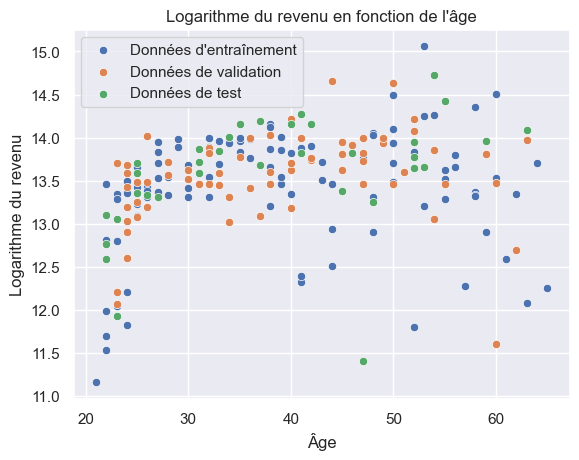

In [48]:
sns.scatterplot(data=train_data, x='age', y='log.income')
sns.scatterplot(data=val_data, x='age', y='log.income')
sns.scatterplot(data=test_data, x='age', y='log.income')

plt.title("Logarithme du revenu en fonction de l'âge")
plt.xlabel("Âge")
plt.ylabel("Logarithme du revenu")
plt.legend(['Données d\'entraînement', 'Données de validation', 'Données de test'])

On voit que les jeux d'entraînement, de validation et de test sont similaires, l'entraînement ne sera donc pas biaisé par la sélection des données.

Text(0, 0.5, 'Log income')

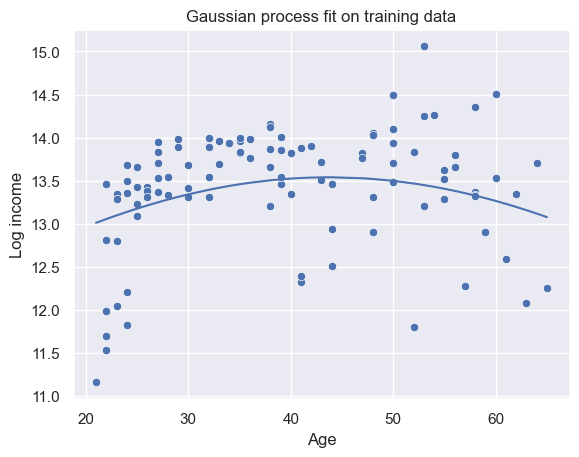

In [5]:
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten())
sns.lineplot(x=X_train.flatten(), y=train_zeta.flatten())
plt.title('Gaussian process fit on training data')
plt.xlabel('Age')
plt.ylabel('Log income')

Text(0, 0.5, 'Log income')

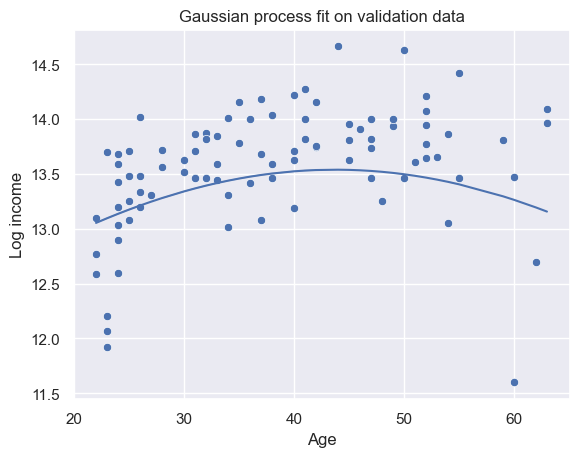

In [6]:
sns.scatterplot(x=X_val.flatten(), y=y_val.flatten())
sns.lineplot(x=X_val.flatten(), y=val_zeta.flatten())
plt.title('Gaussian process fit on validation data')
plt.xlabel('Age')
plt.ylabel('Log income')

In [23]:
# transform data

transformer = ExponentialTransformer()

transformer.fit(y_train)
y_train_transformed = transformer.transform(y_train)
y_val_transformed = transformer.transform(y_val)
y_test_transformed = transformer.transform(y_test)

scaler = StandardScaler()

scaler.fit(y_train_transformed)
y_train_transformed = scaler.transform(y_train_transformed)
y_val_transformed = scaler.transform(y_val_transformed)
y_test_transformed = scaler.transform(y_test_transformed)

# fit Gaussian process to valing data
gp = GaussianProcess(theta=0.5, noise=0.1)

gp.fit(X_train, y_train_transformed)

gp.optimize(X_val, y_val_transformed)

train_zeta, _ = gp.predict(X_train)
val_zeta, _ = gp.predict(X_val)
test_zeta, _ = gp.predict(X_test)

train_zeta = scaler.inverse_transform(train_zeta)
train_zeta = transformer.inverse_transform(train_zeta)
val_zeta = scaler.inverse_transform(val_zeta)
val_zeta = transformer.inverse_transform(val_zeta)
test_zeta = scaler.inverse_transform(test_zeta)
test_zeta = transformer.inverse_transform(test_zeta)

Text(0, 0.5, 'Log income')

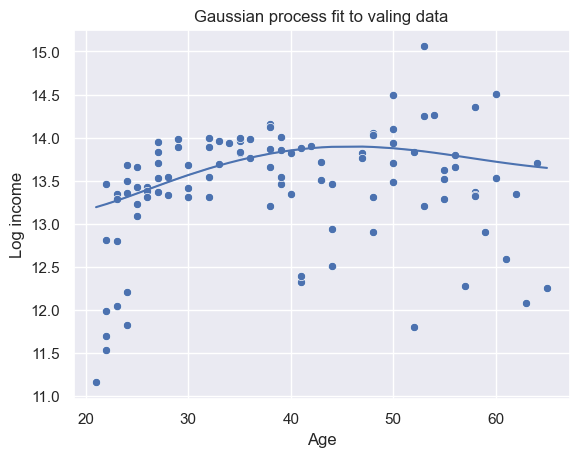

In [24]:
sns.scatterplot(x=X_train.flatten(), y=y_train.flatten())
sns.lineplot(x=X_train.flatten(), y=train_zeta.flatten())
plt.title('Gaussian process fit to valing data')
plt.xlabel('Age')
plt.ylabel('Log income')

Text(0, 0.5, 'Log income')

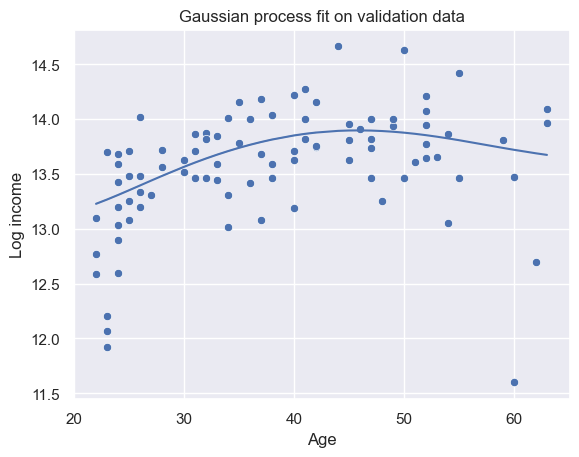

In [25]:
sns.scatterplot(x=X_val.flatten(), y=y_val.flatten())
sns.lineplot(x=X_val.flatten(), y=val_zeta.flatten())
plt.title('Gaussian process fit on validation data')
plt.xlabel('Age')
plt.ylabel('Log income')

In [26]:
print(gp.theta, gp.noise)

22.15123048111018 0.7369236649866693
